# Potresi

V projektni nalogi bom analizirala podatke o potresih od [tukaj](http://www.emsc-csem.org/) (European-Mediterranean Seismological Centre). Odločila sem se za potrese, ki so se zgodili v prvih dveh tednih oktobra (torej do 15. oktobra), ker da ta časovni okvir ravno pravšnje število podatkov - nekaj več kot 1300 potresov.

Na navedeni strani najdete podatke o zadnjih potresih po svetu (podatke sicer pridobivajo avtomatsko od približno 70 opazovalnic, ki so večinoma v Evropi, zaznajo pa seveda potrese z vsega sveta) - na primer čas potresa, lokacijo (v koordinatah in opisno), globino in magnitudo. Kdorkoli lahko prispeva komentar oziroma fotografijo, če je potres začutil ali opazil posledice (recimo razpoke na hiši). Za posamezen potres, ki je pritegnil vašo pozornost, lahko pridobite ogromno podatkov, ki pa jih na tem mestu ne bomo obravnavali, ker za analizo niso posebej zanimivi.

#### Opomba

Če vas potresi zelo zanimajo, si oglejte tudi [to projektno nalogo](https://github.com/TinaKrasovec/Potresi-po-Evropi-zadnjih-nekaj-let-z-magnitudo-4). Podobnost je naključna, poskusili pa sva delati tako, da se analiza ne prekriva preveč. Pri delu nisva sodelovali.

## Uvod
Naložimo csv datoteko in si ogledamo nekaj vrstic za občutek.

In [2]:
import pandas as pd
pd.options.display.max_rows = 15


%matplotlib inline

In [5]:
podatki = pd.read_csv('potresi_koncni.csv', index_col = 'id')

In [36]:
podatki[:8]

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija
id,,,,,,,,,,,,,
537411,2016,10,15,23,40,55.1,E,34.31,N,38.13,4,2.7,CENTRAL TURKEY
537458,2016,10,15,23,17,42.6,E,27.72,N,38.93,6,2.6,WESTERN TURKEY
537380,2016,10,15,23,6,59.1,E,20.69,N,39.76,15,4.3,GREECE
537552,2016,10,15,22,43,13.2,E,38.94,N,19.21,8,3.6,WESTERN TURKEY
537310,2016,10,15,22,30,26.1,E,71.70,N,41.26,15,3.7,EASTERN UZBEKISTAN
537551,2016,10,15,22,27,50.9,E,38.94,N,19.29,8,3.6,WESTERN TURKEY
537553,2016,10,15,22,19,42.0,E,39.75,N,59.75,12,2.6,GREECE
537557,2016,10,15,21,46,52.8,E,20.70,N,39.70,8,4.3,GREECE


## Kje so se zgodili potresi?

Večkrat smo že slišali, da živimo na potresno zelo živahnem območju. Izkaže pa se, da se v smislu potresov v začetku oktobra v Sloveniji ni veliko zgodilo. Opazovalnice so zabeležile en sam potres na našem območju, zato se najbrž spodobi, da ga izpišemo.

In [42]:
podatki[podatki.regija == 'SLOVENIA']

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija
id,,,,,,,,,,,,,
536262,2016,10,10,11,43,41.6,E,14.59,N,45.94,2,2.0,SLOVENIA


In [45]:
podatki.loc[536262]

leto             2016
mesec              10
dan                10
ura                11
minuta             43
sekunda          41.6
DOL                 E
dolzina         14.59
SIR                 N
sirina          45.94
globina             2
magnituda           2
regija       SLOVENIA
Name: 536262, dtype: object

Kako zanimivo! Potres se je zgodil v ponedeljek, 10. oktobra ob 11:43, ko so potekale vaje za programiranje.

V katerih državah pa se je zgodilo največ potresov?

In [56]:
podatki['regija'].value_counts()

WESTERN TURKEY                      242
GREECE                               69
CENTRAL TURKEY                       65
OKLAHOMA                             58
EASTERN TURKEY                       57
VIRGIN ISLANDS REGION                56
CENTRAL ITALY                        54
                                   ... 
SAN FRANCISCO BAY, CALIFORNIA         1
WASHINGTON                            1
OFFSHORE CHIAPAS, MEXICO              1
BULGARIA-GREECE-TURKEY BORDER RG      1
OFFSHORE LOS LAGOS, CHILE             1
OFF COAST OF CENTRAL PERU             1
OFFSHORE MAULE, CHILE                 1
Name: regija, dtype: int64

Turčija je očitno potresno zelo zanimiva država, saj med prvimi petimi regijami nastopi kar trikrat s skupno več kot 350 potresi. Presenetljivo torej že zelo površen pregled pokaže, da se je približno vsak četrti potres zgodil v Turčiji.

Opazimo pa tudi težavo. Sklepali bi, da so potresno aktivna območja deljena v manjše regije (kot zgoraj Turčija in recimo Čile) zato, da tisti, ki se s tem ukvarjajo, že na prvi pogled bolj natančno vedo, kje je bil potres.

?? ?? Recimo pa, da nas ne zanima, v katerem delu države se je potres zgodil, ampak samo država. ?? ??

88888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888

In [ ]:
po_dnevu = podatki.groupby('dan')
po_dnevu.size().plot(kind='bar')

In [ ]:
podatki.groupby('ura')['magnituda'].mean().plot()

In [ ]:
regije = podatki.groupby('regija')
regije['magnituda'].sum().sort_values(ascending=False)[:20]

In [ ]:
regije['magnituda'].mean().sort_values(ascending=False)[:20]

Opazimo razliko med [18] in [19], hipoteza morje - kopno...

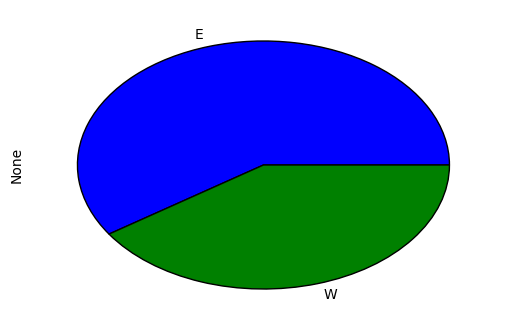

In [6]:
dolzina = podatki.groupby('DOL')
dolzina.size().plot(kind = 'pie')


In [16]:
sirina = podatki.groupby('SIR')
#sirina['magnituda'].mean()
#sirina.size().plot(kind = 'pie')

zanimivo. opazovalnice, Afrika, morje...?

In [ ]:
globina = podatki.groupby('globina')
globina.size().plot()

In [24]:
#podatki.groupby('globina')['magnituda'].mean().plot()
#podatki.groupby('globina')['magnituda'].value_counts().plot()
#podatki.groupby('globina')['magnituda'].size().plot()

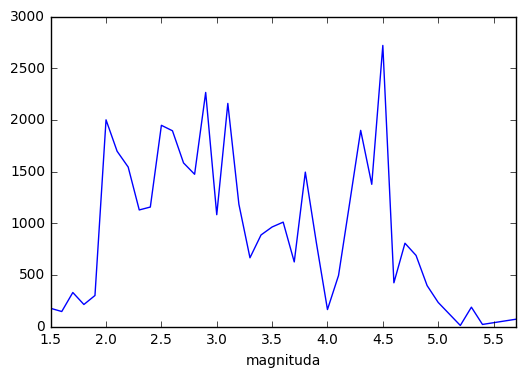

In [26]:
podatki.groupby('magnituda')['globina'].sum().plot()

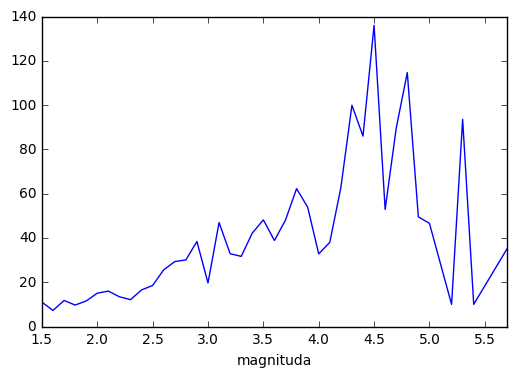

In [25]:
podatki.groupby('magnituda')['globina'].mean().plot()

In [ ]:
podatki.groupby('regija')